In [68]:
try:
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from stargazer.stargazer import Stargazer
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    from sklearn.neural_network import MLPRegressor
    import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel
    

except ModuleNotFoundError:
    !pip install ISLP -q
    !pip install stargazer -q
    !pip install xgboost -q
    !pip install doubleml -q
    !pip install dowhy -q
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import pandas as pd
    import numpy as np
    import os
    import statsmodels.api as sm
    import sklearn.linear_model as lm
    import sklearn.model_selection as skm
    import statsmodels.formula.api as smf
    import matplotlib.pyplot as plt
    from stargazer.stargazer import Stargazer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from ISLP.models import ModelSpec as MS
    from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
    from sklearn.metrics import (accuracy_score,
                             log_loss,
                                mean_squared_error)
    from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
    from ISLP.bart import BART
    import xgboost as xgb
    from sklearn.model_selection import cross_val_predict
    import doubleml as dml
    import graphviz
    import networkx as nx
    import dowhy
    from dowhy import CausalModel

In [2]:
data_loc = "spillovers.dta"

data = pd.read_stata(data_loc, iterator=True)

In [3]:
data.variable_labels()

{'cusip': 'CUSIP',
 'year': 'year',
 'xrd': 'Expenditure on R&D',
 'ppent': 'Net book value of property, plant and equipment',
 'spillsic': 'SIC correlation weighted R&D of other firms, 1996 values',
 'spillcovsic': '',
 'spillmalsic': '',
 'spillmalcovsic': '',
 'spilltec': 'Patent NClass correlation weighted R&D of other firms, 1996 values',
 'spillcovtec': '',
 'spillmaltec': '',
 'spillmalcovtec': '',
 'spilltloc': '',
 'spillsloc': '',
 'spilltectloc': '',
 'spilltecsloc': '',
 'spillsicsloc': '',
 'spillsictloc': '',
 'lstate': '',
 'lfirm': '',
 'firm_dum': '',
 'hxrd': '',
 'spillsicIV': '',
 'spilltecIV': '',
 'spillsicIV_mal': '',
 'spilltecIV_mal': '',
 'p005': '',
 'sales_ind': 'Control variable - Total sales weighted by sic sales matrix',
 'sales_ind_ns': 'Control variable - Total Value Shipments in Manufacturing from National Statisti',
 'patents_ind': 'Control variable - Total number of patents weighted by tech matrix',
 'pat_count': 'Patents per firm applied for that ye

In [4]:
vars_of_int = ['i','year','rmkvaf','grd','grd_k1','rxrd','gspillsic','gspilltec','pat_count','pat_cite','rsales',
              'rppent','emp','gspilltecIV','gspillsicIV']

data = pd.read_stata(data_loc)
df = data[vars_of_int]
df.columns

Index(['i', 'year', 'rmkvaf', 'grd', 'grd_k1', 'rxrd', 'gspillsic',
       'gspilltec', 'pat_count', 'pat_cite', 'rsales', 'rppent', 'emp',
       'gspilltecIV', 'gspillsicIV'],
      dtype='object')

In [5]:
# convert categorical columns to strings
df['year'] = df['year'].astype(str)
df['i'] = df['i'].astype(str)

/tmp/ipykernel_554/3340598184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(str)
/tmp/ipykernel_554/3340598184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = df['i'].astype(str)


In [6]:
var_of_int_noindex = ['rmkvaf','gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']

# delete NaN values

df = df.dropna(axis=0)

#for i in range(0, len(var_of_int_noindex)):
#    df = df[df[var_of_int_noindex[i]].isna() == False]

#df = df.loc[df['rmkvaf'].isna() == False]

df_sum_stats = df[var_of_int_noindex].describe()
df_sum_stats = df_sum_stats.round(2)
df_sum_stats

,rmkvaf,gspilltecIV,gspillsicIV,pat_count,rsales,rppent,emp,rxrd
count,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00,11736.00
mean,3449.07,20747.15,5980.43,18.43,2728.76,1289.43,18.36,101.31
std,13571.64,15482.72,8665.92,80.25,8369.00,3991.58,53.39,457.04
min,0.43,230.28,4.46,0.00,1.48,0.96,0.10,0.00
25%,86.55,8901.98,596.31,0.00,113.19,26.77,1.08,0.00
50%,395.46,17242.42,2027.41,1.00,433.49,116.75,3.71,4.53
75%,1934.38,29073.87,7382.01,6.00,1876.15,710.58,13.53,29.16
max,485566.69,91985.96,55576.60,2405.00,137513.77,72707.55,876.80,8900.00


In [7]:
#df_sum_stats.T.to_excel("sum_stats.xlsx") # export summary statistics
print(df_sum_stats.T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
rmkvaf & 11736.000000 & 3449.070000 & 13571.640000 & 0.430000 & 86.550000 & 395.460000 & 1934.380000 & 485566.690000 \\
gspilltecIV & 11736.000000 & 20747.150000 & 15482.720000 & 230.280000 & 8901.980000 & 17242.420000 & 29073.870000 & 91985.960000 \\
gspillsicIV & 11736.000000 & 5980.430000 & 8665.920000 & 4.460000 & 596.310000 & 2027.410000 & 7382.010000 & 55576.600000 \\
pat_count & 11736.000000 & 18.430000 & 80.250000 & 0.000000 & 0.000000 & 1.000000 & 6.000000 & 2405.000000 \\
rsales & 11736.000000 & 2728.760000 & 8369.000000 & 1.480000 & 113.190000 & 433.490000 & 1876.150000 & 137513.770000 \\
rppent & 11736.000000 & 1289.430000 & 3991.580000 & 0.960000 & 26.770000 & 116.750000 & 710.580000 & 72707.550000 \\
emp & 11736.000000 & 18.360000 & 53.390000 & 0.100000 & 1.080000 & 3.710000 & 13.530000 & 876.800000 \\
rxrd & 11736.000000 & 101.310000 & 457.040000 & 0.000000 & 0.000000 & 4.

# OLS Regression

In [8]:
# Run linear model
# gen fixed effects
time_effects = pd.get_dummies(df['year'])
#time_effects.columns = time_effects.columns.astype(str)
firm_effects = pd.get_dummies(df['i'])
#time_effects.columns = time_effects.columns.astype(str)


df = pd.merge(df, time_effects, left_on=df.index, right_on=time_effects.index, how='left')

df = df.rename(columns={'key_0': 'old_key'})

df = pd.merge(df, firm_effects, left_on=df['old_key'], right_on=firm_effects.index, how='left')

fixed_effects = list(time_effects.columns.values)
for col in firm_effects.columns.values:
    fixed_effects.append(col)

y_var = df['rmkvaf']

# get df for x vars + fixed effects
x_vars = ['gspilltecIV','gspillsicIV','pat_count','rsales','rppent','emp','rxrd']
for col in fixed_effects:
    x_vars.append(col)


In [10]:
x_vars = df[x_vars]
x_vars = sm.add_constant(x_vars)
x_vars = x_vars.astype(float) # converts categorical booleans to floats

lin_reg = sm.OLS(y_var,x_vars).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rmkvaf   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     28.98
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:50:43   Log-Likelihood:            -1.2192e+05
No. Observations:               11736   AIC:                         2.454e+05
Df Residuals:                   10985   BIC:                         2.509e+05
Df Model:                         750                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6271.8534    532.282    -11.783      0.000   -7315.222   -5228.485
gspilltecIV     0.1630      0.028      5.768      0.000       0.108       0.218
gspillsicIV     0.4887      0.052      9.386      0.000       0.387       0.591
pat_count     -29.4376      1.715    -17.168      0.000     -32.799     -26.076
rsales          1.0154      0.041     24.569      0.000       0.934       1.096
rppent          0.5175      0.087      5.962      0.000       0.347       0.688
emp            -2.5097      7.030     -0.357      0.721     -16.291      11.271
rxrd            8.6216      0.669     12.878      0.000       7.309       9.934
1981          762.8261    381.627      1.999      0.046      14.769    1510.883
1982          883.7420    369.574      2.391      0.017     159.310    1608.174
1983          821.5707    357.444      2.298      0.022     120.917    1522.225
1984          310.9095    346.828      0.896      0.370    -368.935     990.754
1985          112.7209    339.088      0.332      0.740    -551.953     777.395
1986         -152.9965    330.737     -0.463      0.644    -801.300     495.307
1987         -423.0556    324.228     -1.305      0.192   -1058.600     212.489
1988         -777.3124    321.303     -2.419      0.016   -1407.124    -147.500
1989         -661.1419    317.261     -2.084      0.037   -1283.031     -39.252
1990        -1153.5785    313.432     -3.680      0.000   -1767.961    -539.196
1991         -798.2414    312.074     -2.558      0.011   -1409.962    -186.521
1992         -982.2983    312.534     -3.143      0.002   -1594.921    -369.676
1993         -999.6691    313.254     -3.191      0.001   -1613.703    -385.635
1994        -1323.3880    317.300     -4.171      0.000   -1945.352    -701.424
1995         -816.2328    325.043     -2.511      0.012   -1453.375    -179.091
1996         -732.9858    338.616     -2.165      0.030   -1396.733     -69.238
1997         -349.2790    356.979     -0.978      0.328   -1049.022     350.464
1998         -247.3364    381.255     -0.649      0.517    -994.665     499.993
1999          253.8930    408.826      0.621      0.535    -547.480    1055.266
10005.0      3097.6615   1880.996      1.647      0.100    -589.430    6784.753
10006.0      2317.7560   2276.237      1.018      0.309   -2144.079    6779.591
10008.0      1438.1417   1886.554      0.762      0.446   -2259.844    5136.127
10016.0      2713.9470   1892.028      1.434      0.151    -994.769    6422.663
10030.0      5086.2191   1901.323      2.675      0.007    1359.283    8813.155
1004.0       4105.1769   1889.911      2.172      0.030     400.612    7809.742
10056.0      1739.8066   1873.446      0.929      0.353   -1932.485    5412.099
10085.0     -3584.2178   1887.069     -1.899      0.058   -7283.212     114.777
10092.0      3969.6072   4695.384      0.84

In [10]:
# export results, omit fixed effects
stargazer = Stargazer([lin_reg])

main_vars = [col for col in x_vars.columns if col not in fixed_effects]
cov_labels = {'rmkvaf': 'Market Value',
             'pat_count': 'Patent Count',
             'rsales': 'Sales',
             'rppent': '',
             'emp': 'Employment',
             'rxrd': 'R&D Expenditures'}


stargazer.covariate_order(main_vars)
stargazer.add_line("Firm & Time Effects", ['Yes'])
#stargazer.rename_covariates(cov_labels)
stargazer

In [11]:
# render to latex
print(stargazer.render_latex())

NameError: name 'stargazer' is not defined

# Ridge Regression

In [12]:
# design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns])).fit(df)
# NOTE: including all of the fixed effects seems to kill the notebook. Running Ridge/LASSO on subset excluding FE's

# Check: outlier in dataset driving a split in reg tree.
## Drop two outlier firms: i = 5047, i = 12141, i = 6008
df = df.loc[(df['i'] != '5047.0') & (df['i'] != '12141.0') & (df['i'] != '6008.0')]

design = MS(df.columns.drop([col for col in df.columns if col not in x_vars.columns or col in fixed_effects])).fit(df)
Y = np.array(df['rmkvaf'])
X = design.transform(df)

D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [13]:
df[['i','rmkvaf']].sort_values('rmkvaf', ascending=False)

,i,rmkvaf
785,20779.0,194111.171875
5965,62599.0,190356.171875
4626,6066.0,183853.468750
6493,7257.0,168679.343750
4625,6066.0,163628.187500
...,...,...
8873,9230.0,1.155449
948,13923.0,0.985430
9542,9799.0,0.718651
9543,9799.0,0.617000


In [14]:
design

ModelSpec(terms=Index(['rxrd', 'pat_count', 'rsales', 'rppent', 'emp', 'gspilltecIV',
       'gspillsicIV'],
      dtype='object'))

In [15]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = lm.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692474979059.0005, tolerance: 138513639.2459772
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did 

(7, 100)

In [16]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'

soln_path

,rxrd,pat_count,rsales,rppent,emp,gspilltecIV,gspillsicIV
negative log(lambda),,,,,,,
-9.167990,0.639117,0.386651,0.641837,0.580663,0.482584,0.281462,0.211692
-8.935406,0.806396,0.487844,0.809826,0.732642,0.608881,0.355125,0.267103
-8.702821,1.017432,0.615504,1.021757,0.924375,0.768208,0.448054,0.337010
-8.470237,1.283655,0.776541,1.289107,1.166247,0.969189,0.565280,0.425201
-8.237653,1.619474,0.979666,1.626344,1.471347,1.222693,0.713142,0.536452
...,...,...,...,...,...,...,...
12.927523,2655.969827,329.826780,2902.989773,1852.216527,-1012.994917,186.880161,982.580331
13.160108,2655.970437,329.826109,2902.995806,1852.215856,-1012.999948,186.879590,982.580723
13.392692,2655.970921,329.825577,2903.000587,1852.215323,-1013.003935,186.879138,982.581034


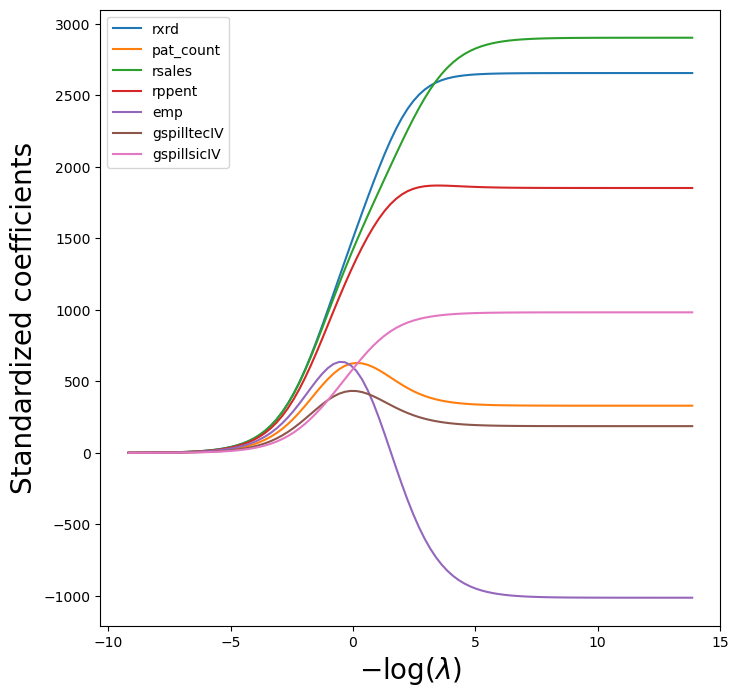

In [17]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left')

# save figure
plt.savefig('ridge_coef.png')

## Cross-Validation plot

In [18]:
# Using K-fold CV w/ K=5
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)
ridge = lm.ElasticNet(alpha=lambdas[59], l1_ratio=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])

param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error') 
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

ridgeCV = lm.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

tuned_ridge = pipeCV.named_steps['ridge']

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.280e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.443e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.028e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.847e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.802e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.478e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.129e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.881e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.581e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.333e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.747e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.732e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.217e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.213e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e+11, tolerance: 9.298e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+11, tolerance: 1.051e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.209e+11, tolerance: 1.056e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+11, tolerance: 1.057e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e+11, tolerance: 9.926e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316873049894.24744, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316857801712.4983, tolerance: 105705701.29629055
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordina

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 311051219264.0425, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 305030072647.7236, tolerance: 92975378.35672489
  model = cd_fast.enet_coordinate_descent_gram(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: UserWarning: Coordinate 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.877e+11, tolerance: 1.272e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


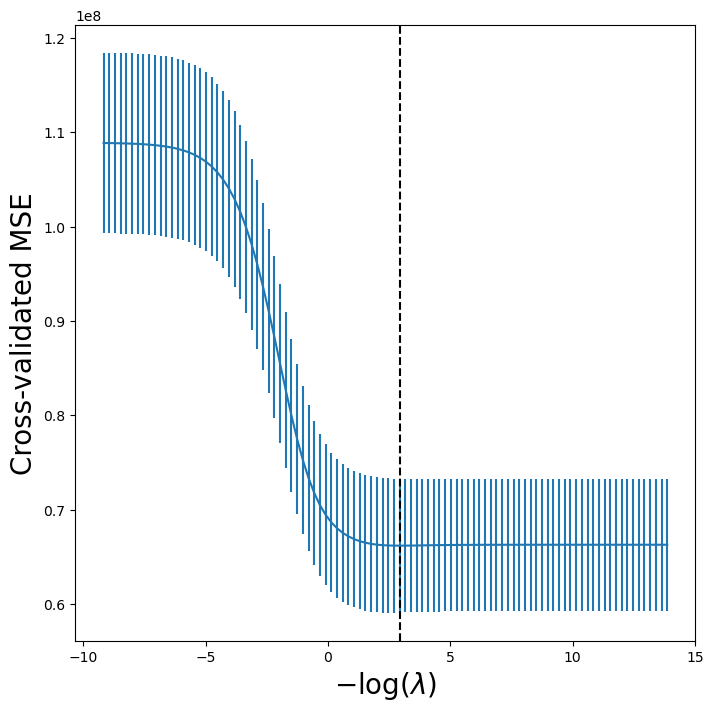

In [19]:
# Plot results
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
#ax.set_ylim([80000000,220000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('ridge_cv.png')

# LASSO Regression

In [20]:
lassoCV = lm.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

6.154565207638776

In [21]:
lambdas, soln_array = lm.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

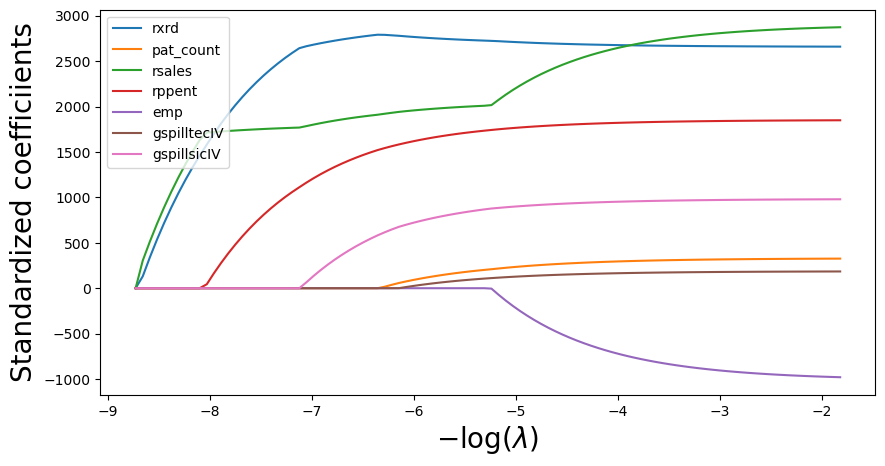

In [22]:
path_fig, ax = plt.subplots(figsize=(10,5))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

# save figure
plt.savefig('lasso_coef.png')

## Cross-Validation plot

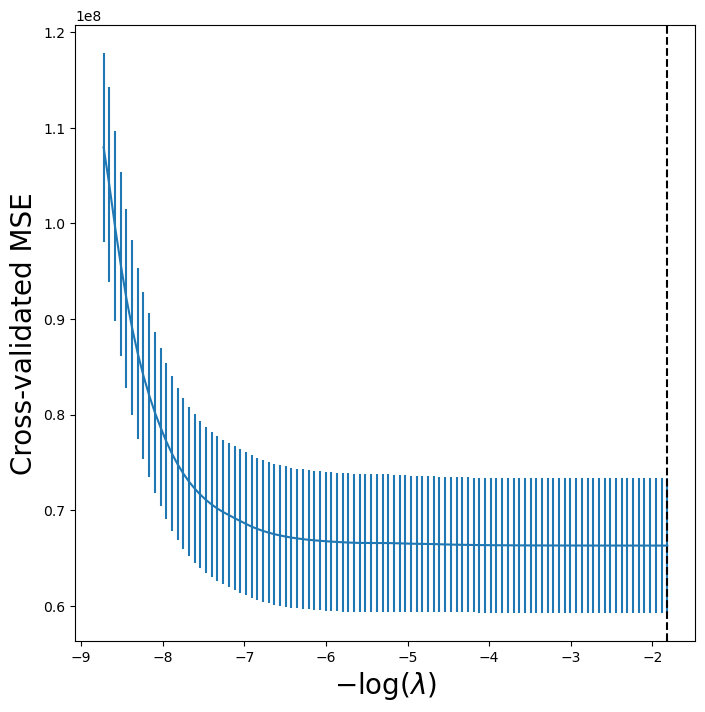

In [23]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
#ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

# save figure
plt.savefig('lasso_cv.png')

In [24]:
# comparing lambdas

# tuned alphas
print("LASSO: ", tuned_lasso.alpha_)
print("Ridge: ", tuned_ridge.alpha_)

LASSO:  6.154565207638776
Ridge:  0.05358981380658186


In [25]:
print(-np.log(tuned_lasso.alpha_))

-1.8171941166276557


# Regression Tree

In [26]:
# Splitting sample
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0)
feature_names = list(D.columns)

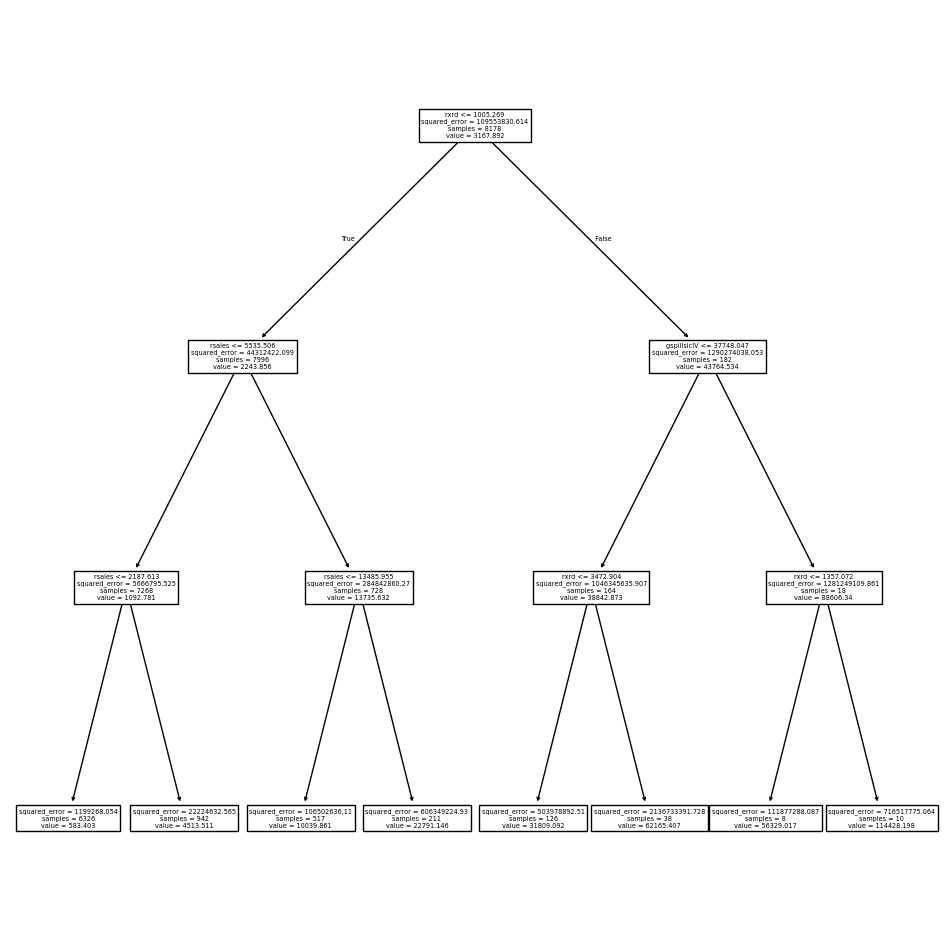

In [27]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [28]:
# Find best pruning for tree
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True, # retrains on best alpha
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [29]:
# Get prediction error
best_ = grid.best_estimator_
tree_mse = np.mean((y_test - best_.predict(X_test))**2)
tree_mse

48364442.48004447

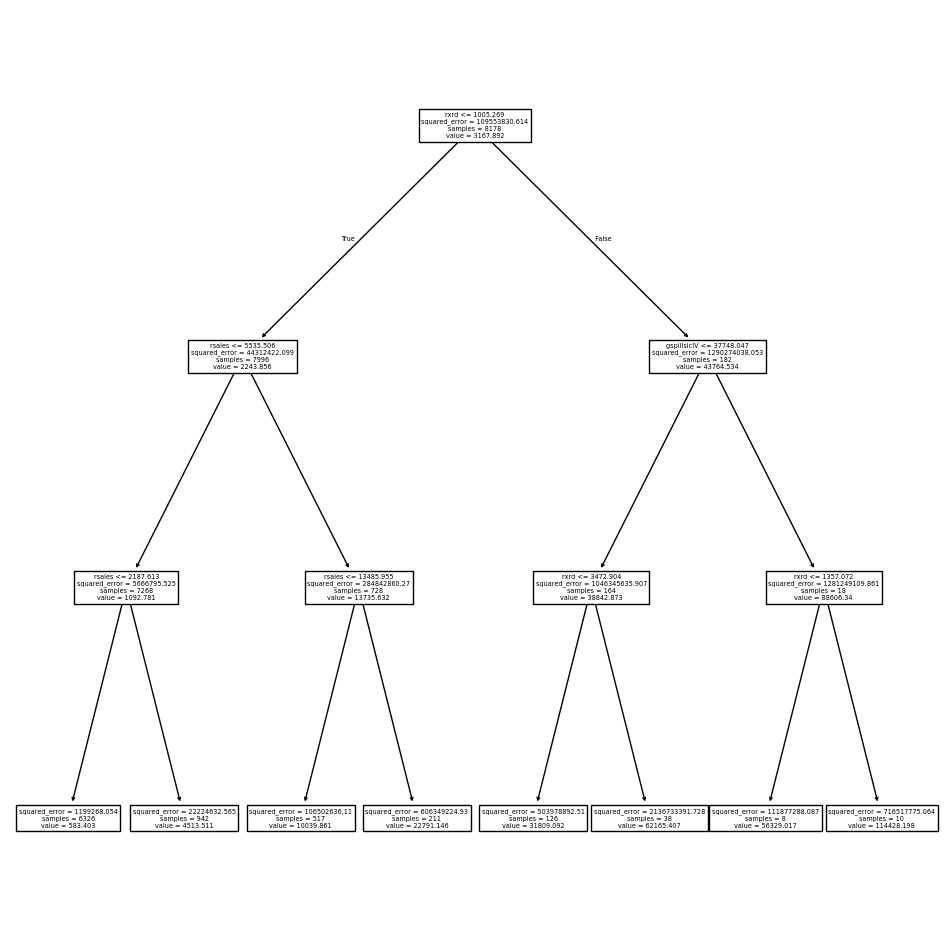

In [30]:
# Output pruned Regression Tree
ax = plt.subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
plt.savefig("pruned_tree.png")

# Random Forest

In [31]:
RF_tree = RF(max_features=3, # Random forest model
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_tree.predict(X_test)
rf_mse = np.mean((y_test - y_hat_RF)**2)
rf_mse

19778946.4332678

In [32]:
feature_imp = pd.DataFrame(
    {'importance':RF_tree.feature_importances_},
    index=feature_names) # Must include feature importance in report
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
rxrd,0.275551
rsales,0.264674
rppent,0.112891
gspillsicIV,0.111112
emp,0.103030
gspilltecIV,0.084416
pat_count,0.048326


Text(0.5, 1.0, 'Importance of Random Forest Regressors for Firm Market Value')

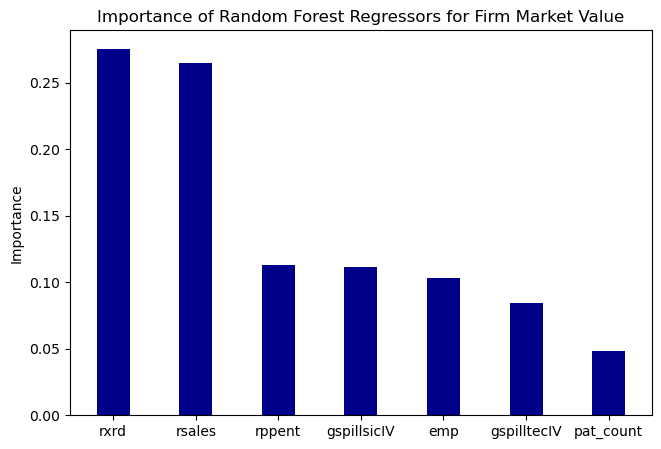

In [33]:
# print(feature_imp.sort_values(by='importance', ascending=False).to_latex()) # print latex output

# plot importance values
fig = plt.figure(figsize=(7.5,5))

plt.bar(feature_imp.index, feature_imp.importance, color ='darkblue', 
        width = 0.4)
plt.ylabel('Importance')
plt.title('Importance of Random Forest Regressors for Firm Market Value')

# Bagging

In [34]:
bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)

RandomForestRegressor(max_features=7, random_state=0)

20762300.97510542

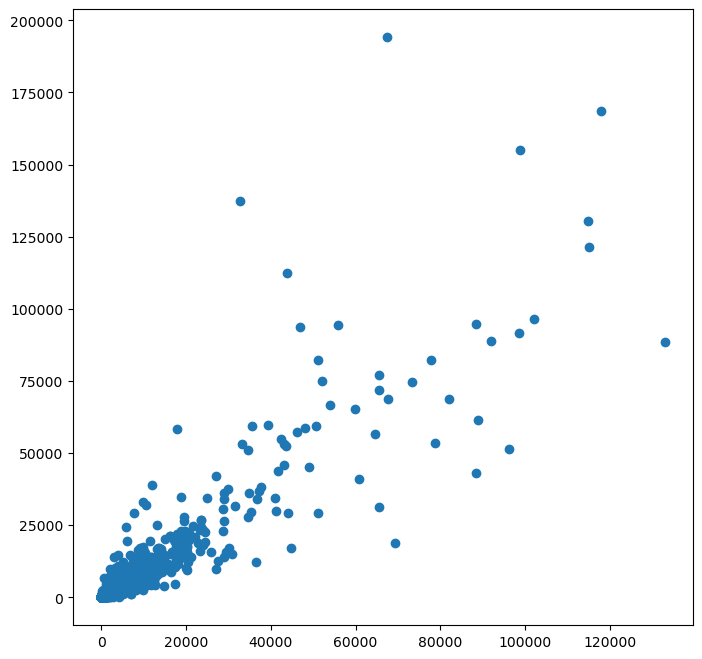

In [35]:
ax = plt.subplots(figsize=(8,8))[1]
y_hat_bag = bag.predict(X_test)
ax.scatter(y_hat_bag, y_test)
bag_mse = np.mean((y_test - y_hat_bag)**2)
bag_mse

# Boosting

In [36]:
boost = GBR(n_estimators=5000, # Gradient Boosting Regressor
                   learning_rate=0.001,
                   max_depth=3,
                   random_state=0)
boost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

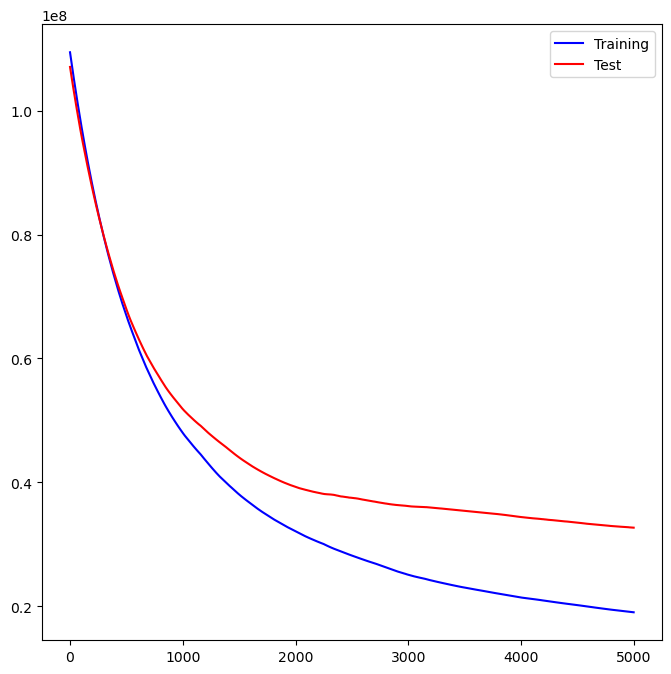

In [37]:
test_error = np.zeros_like(boost.train_score_)
for idx, y_ in enumerate(boost.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost.train_score_.shape[0])
ax = plt.subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

boost_mse = min(test_error)

Mean Squared Error: 38336824.0
Prev. MSE: 40865396.0


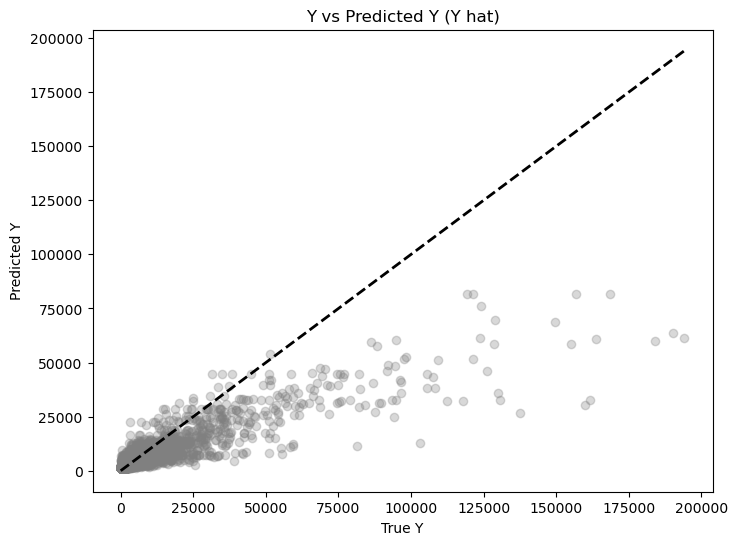

In [38]:
# XG Boost
y = df['rmkvaf']
# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)
print("Prev. MSE: 40865396.0")

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='grey', alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

# Comparing Test Errors

In [39]:
# Tree
print('Tree: ', tree_mse)
# Bag
print('Bag: ', bag_mse)
# Random Forest
print('Random Forest: ', rf_mse)
# Boost
print('Boost: ', boost_mse)

# Make table
error_tbl = {
    'model' : ['Tree', 'Bag', 'Random Forest', 'Boost'],
    'MSE' : [tree_mse, bag_mse, rf_mse, boost_mse]
}
error_tbl = pd.DataFrame(data=error_tbl)
print(error_tbl.to_latex())

Tree:  48364442.48004447
Bag:  20762300.97510542
Random Forest:  19778946.4332678
Boost:  32668619.48609114
\begin{tabular}{llr}
\toprule
 & model & MSE \\
\midrule
0 & Tree & 48364442.480044 \\
1 & Bag & 20762300.975105 \\
2 & Random Forest & 19778946.433268 \\
3 & Boost & 32668619.486091 \\
\bottomrule
\end{tabular}



# Predicting Market value of spillovers across years

In [30]:
# Use Optimal LASSO coefficients - remember to rescale from their standardization back to unit values.
print(x_vars.columns[1],': ',tuned_lasso.coef_[0]) # index 0 for x_vars is constant term
print(x_vars.columns[2],': ',tuned_lasso.coef_[1]) # so 1st variable is at index 1


gspilltecIV :  2657.6857955701757
gspillsicIV :  325.8887086615884


In [38]:
# rescaling lasso coefficients
coef_tec = tuned_lasso.coef_[0]/df['gspilltecIV'].std()
coef_sic = tuned_lasso.coef_[1]/df['gspillsicIV'].std() 

In [39]:
df['firmval_tec'] = df['gspilltecIV']*coef_tec
df['firmval_sic'] = df['gspillsicIV']*coef_sic

In [40]:
df[['rmkvaf','firmval_tec','firmval_sic']]

,rmkvaf,firmval_tec,firmval_sic
0,2314.207764,3473.012695,377.431091
1,1288.770630,3390.965088,368.395996
2,1756.920532,3340.894043,362.991760
3,8698.285156,3321.720459,358.800262
4,10707.480469,3362.202881,362.979736
...,...,...,...
11731,765.484863,5178.813965,1174.952026
11732,910.333008,5190.939453,1177.405029
11733,1200.901245,5270.196289,1194.081299
11734,1264.767578,5391.985352,1221.722046


In [41]:
print(df['rmkvaf'].sum())
print(df['firmval_tec'].sum())
# Generate predictions for each firm

# Aggregate across years

36409750.0
41708496.0


# Impact of spillovers on firm value over time

In [42]:
# Include confidence intervals. Use 2 or 5 year intervals if need more statistical power
# Try with PLR DML to compare results - separate bar i.e. for each year, one OLS bar and one DML bar
# Separate plots for tech/product market spillovers
# Estimate effect of spillovers on firm value, OLS

# grab estimates. Add non-interactive term to each year coefficient

# Estimate effect of spillovers on firm value, DML



,const,gspilltecIV,gspillsicIV,pat_count,rsales,rppent,emp,rxrd,1981,1982,...,9778.0,9799.0,9815.0,9818.0,9837.0,9922.0,9954.0,9963.0,9988.0,9999.0
0,1.0,20052.304688,10040.360352,15.0,278.761078,56.617451,2.051,16.331957,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,19578.582031,9800.009766,26.0,328.719727,87.188660,2.349,22.328802,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,19289.484375,9656.247070,36.0,381.802734,117.699867,2.838,26.039793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,19178.781250,9544.746094,33.0,934.966187,258.918335,7.042,122.323624,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,19412.515625,9655.927734,32.0,1232.714966,347.000000,9.580,212.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11731,1.0,29901.171875,31255.880859,43.0,1089.344238,533.127136,8.600,37.716450,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11732,1.0,29971.181641,31321.136719,49.0,1247.974121,534.000000,9.800,54.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11733,1.0,30428.791016,31764.755859,39.0,1425.000000,600.309387,10.400,57.872967,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11734,1.0,31131.970703,32500.050781,11.0,1452.403564,615.288025,10.100,62.982235,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# DAG model and testing

In [58]:
DAG3 = """graph [
directed 1

node [
    id 0
    label "rmkvaf"
    ]

node [
    id 1
    label "rxrd"
    ]
    
node [
    id 2
    label "rsales"
    ]

node [
    id 3
    label "gspilltecIV"
    ]

node [
    id 4
    label "gspillsicIV"
    ]

node [
    id 5
    label "pat_count"
    ]

node [
    id 7
    label "rppent"
    ]

edge [
    source 5
    target 0
    ]

edge [
    source 5
    target 7
    ]


edge [
    source 3
    target 1
    ]


edge [
    source 4
    target 1
    ]


edge [
    source 4
    target 2
    ]


edge [
    source 1
    target 7
    ]


edge [
    source 1
    target 5
    ]


edge [
    source 7
    target 2
    ]


edge [
    source 2
    target 0
    ]

edge [
    source 7
    target 0
    ]

]
    
    """

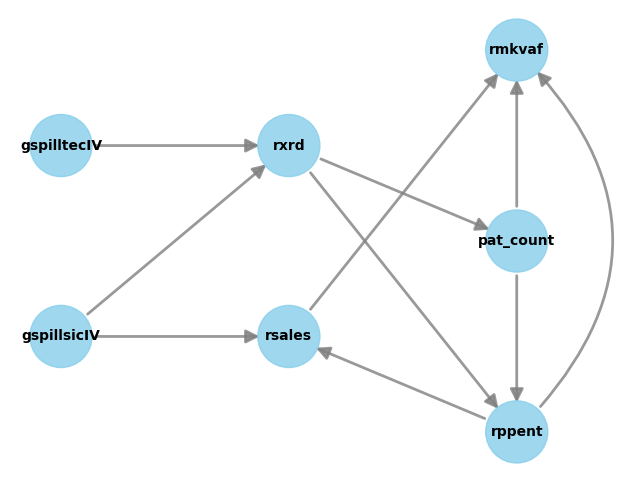

In [59]:
model = CausalModel(
    data=df,
    treatment='gspilltecIV',
    outcome='rmkvaf',
    graph=DAG3)

model.view_model()

In [60]:
# identify estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[rmkvaf])
d[gspilltecIV]           
Estimand assumption 1, Unconfoundedness: If U→{gspilltecIV} and U→rmkvaf then P(rmkvaf|gspilltecIV,,U) = P(rmkvaf|gspilltecIV,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡                d                                ∂                          
E⎢──────────────────────────────────(rmkvaf)⋅──────────────([rppent  pat_count
 ⎣d[rppent  pat_count  rxrd  rsales]         ∂[gspilltecIV]                   

                ⎤
  rxrd  rsales])⎥
                ⎦
Estimand assumption 1, Full-mediation: rppent,pat_count,rxrd,rsales intercepts (blocks) all directed paths from gspilltecIV to r,m,k,v,a,f.
Estimand assumption 2, First-stage-unconfoundedness: If U→{gspilltecIV} and U→{rppent,pat_count,rxrd,rsales} then P(rppent,pat

In [70]:
# obtain estimates
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(estimate.value)

0.12235131659838316


In [71]:
# refutation test
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.12235131659838316
New effect:0.12114140252217734
p value:0.94



# Scrap Code

gspilltecIV :  2657.6857955701757
gspillsicIV :  325.8887086615884


In [44]:
X_spills = df[['gspilltecIV', 'gspillsicIV']]

(X_trainsp,
 X_testsp,
 y_trainsp,
 y_testsp) = skm.train_test_split(X_spills,
                                df['rmkvaf'],
                                test_size=0.3,
                                random_state=0) 

In [ ]:
# Try a neural network
one_layers = [
    (1),
    (2),
    (3),
    (4),
    (5)
]

two_layers = [
    (1,1),(1,2),(1,3),
    (2,1),(2,2),(2,3),(2,4),
    (3,1),(3,2),(3,3),(3,4),(3,5),
    (4,1),(4,2),(4,3),(4,4),(4,5),
    (5,1),(5,2),(5,3),(5,4),(5,5)
]

# Use DML with a PLR equation, keeping spillovers entering linearly
# Use Random Forest as the ML model

# Specify doubleML data model

x_vars = ['pat_count','rsales','rppent','emp','rxrd']
data_dml_tec = dml.DoubleMLData(df,
                                 y_col='rmkvaf',
                                 d_cols='gspilltec',
                                 x_cols=x_vars)

RF_DML = RF(max_features=3, random_state=0)

# Implement PLR DML estimation with gspilltec linear

dml_plr_tec = dml.DoubleMLPLR(data_dml_tec,
                                ml_l = RF_DML,
                                ml_m = RF_DML,
                                n_folds = 3)

dml_plr_tec.fit(store_predictions=True)
print(dml_plr_tec.summary)